In [2]:
import numpy as np
# import torch
import math
# from torch import nn
# import torch.nn.functional as F
# from torch import distributions as pyd

from utils import util, buffer
from utils.util import unpack_batch
# import pandas as pd
import matplotlib as mpl
from matplotlib import pyplot as plt
# from sklearn.decomposition import NMF
from utils import util, buffer
import pickle
# import h5py

import os
from sklearn.decomposition import PCA
from visualize import plot_gif


ALSA lib confmisc.c:855:(parse_card) cannot find card '0'
ALSA lib conf.c:5178:(_snd_config_evaluate) function snd_func_card_inum returned error: No such file or directory
ALSA lib confmisc.c:422:(snd_func_concat) error evaluating strings
ALSA lib conf.c:5178:(_snd_config_evaluate) function snd_func_concat returned error: No such file or directory
ALSA lib confmisc.c:1334:(snd_func_refer) error evaluating name
ALSA lib conf.c:5178:(_snd_config_evaluate) function snd_func_refer returned error: No such file or directory
ALSA lib conf.c:5701:(snd_config_expand) Evaluate error: No such file or directory
ALSA lib pcm.c:2664:(snd_pcm_open_noupdate) Unknown PCM default
ALSA lib confmisc.c:855:(parse_card) cannot find card '0'
ALSA lib conf.c:5178:(_snd_config_evaluate) function snd_func_card_inum returned error: No such file or directory
ALSA lib confmisc.c:422:(snd_func_concat) error evaluating strings
ALSA lib conf.c:5178:(_snd_config_evaluate) function snd_func_concat returned error: No su

In [3]:
fit_soft_info = pickle.load(open('./keymoseq/fit_soft_info.pkl', 'rb'))
print(fit_soft_info.keys())
average_state_ar, average_action_ar, initial_state, initial_task, u_matrix = \
    fit_soft_info['average_state_ar'], fit_soft_info['average_action_ar'], \
    fit_soft_info['initial_state'], fit_soft_info['initial_task'], \
    fit_soft_info['u_matrix']
print(average_state_ar.shape, average_action_ar.shape, initial_state.shape, initial_task.shape, u_matrix.shape)

dict_keys(['average_state_ar', 'average_action_ar', 'initial_state', 'initial_task', 'u_matrix'])
(64, 16) (64, 16) (250, 16) (250, 1) (250, 64)


In [18]:
from plot import get_edges
def show_sa_all(axs, state_all, action_all, skill_all, skill_cmap, skill_colors=None, mapping=None):
  # state_all: [n_sample, state_dim]
  # action_all: [n_sample, action_dim]
  edges, state_name, n_dim = get_edges(state_all.shape[-1])
  n_bodyparts = len(state_name)
  n_sample = state_all.shape[0]
  state_seqs_to_plot = state_all.reshape(-1, n_bodyparts, 2)
  action_seqs_to_plot = action_all.reshape(-1, n_bodyparts, 2)
  cmap = plt.cm.get_cmap('summer')
  keypoint_colors = cmap(np.linspace(0, 1, len(state_name)))
  axmin = -0.25
  axmax = 0.25
  aymin = -0.25
  aymax = 0.25
  xym = [axmin, axmax, aymin, aymax]
  if skill_colors is None:
    skill_colors = [skill_cmap.colors[i%len(skill_cmap.colors)] for i in range(n_sample)]
  for i in range(n_sample):
    if i in mapping:
      origin_syllable = mapping[i]
    else:
      origin_syllable = None
    show_sa_single(axs[i], skill_all[i], state_seqs_to_plot[i], action_seqs_to_plot[i], 
                   edges, keypoint_colors, skill_colors[i], axspine_width=5, xym=xym,
                   origin_syllable=origin_syllable)


def show_sa_single(ax, syllable, state, action, edges, keypoint_colors, syllable_color, axspine_width=5, xym=[-0.3,0.3,-0.3,0.3],
                   origin_syllable=None):
  show_s(ax, state, edges, keypoint_colors)
  show_a(ax, state, action)
  if origin_syllable is None:
    ax.set_title(f'{syllable}', fontsize=15)
  else:
    ax.set_title(f'{syllable} (skill {origin_syllable})', fontsize=15)
  ax.set_xlim(xym[0], xym[1])
  ax.set_ylim(xym[2], xym[3])
  ax.set_xticks([])
  ax.set_yticks([])
  set_ax_color_width(ax, syllable_color, axspine_width)

def show_s(ax, state_seq, edges, keypoint_colors):
  # state_seq: [n_bodyparts, 2]
  '''
      for p1, p2 in edges:
        axis.plot(
            *state_seqs_to_plot[i, (p1, p2)].T,
            color=keypoint_colors[p1],
            linewidth=5.0,zorder=i*4)
      for p1, p2 in edges:
        axis.plot(
            *state_seqs_to_plot[i, (p1, p2)].T,
            color='black',
            linewidth=5.0*0.9,zorder=i*4+1)
      axis.scatter(
          *state_seqs_to_plot[i].T,
          c=keypoint_colors,
          edgecolors='black',
          s=100,zorder=i*4+2)'''
  for p1, p2 in edges:
    ax.plot(
        *state_seq[(p1, p2), :].T,
        color=keypoint_colors[p1],
        linewidth=2.0, zorder=0)
  for p1, p2 in edges:
    ax.plot(
        *state_seq[(p1, p2), :].T,
        color='black',
        linewidth=2.0*0.9, zorder=1)
  ax.scatter(
      *state_seq.T,
      c=keypoint_colors,
      edgecolors='black',
      s=50, zorder=2)
def show_a(ax, state_seq, action_seq):
  n_bodyparts = state_seq.shape[0]
  for k in range(n_bodyparts):
    ax.quiver(state_seq[k, 0], state_seq[k, 1], 
              action_seq[k, 0], action_seq[k, 1], 
              angles='xy', scale_units='xy', scale=0.07, color='r',
              width=0.02, headwidth=3, headlength=3, headaxislength=2,
              zorder=3)
def set_ax_color_width(ax, color, linewidth):
  # ax.axis('off')
  for spine in ax.spines.values():
    spine.set_color(color)
    spine.set_linewidth(linewidth)

In [19]:
cmap = plt.get_cmap('tab10')
colors = cmap.colors
print(len(colors), len(colors[0]))

10 3


In [39]:
colordict = {57: colors[7], 45: colors[6], 23: colors[3], 58: colors[8], 43: colors[5], 6: colors[1]}
mapping = {57:1, 45:2, 23:3, 58:4, 43:5, 6:6}
np.random.seed(0)
for i in range(average_state_ar.shape[0]):
  if i not in colordict:
    colordict[i] = tuple(np.random.rand(3,))

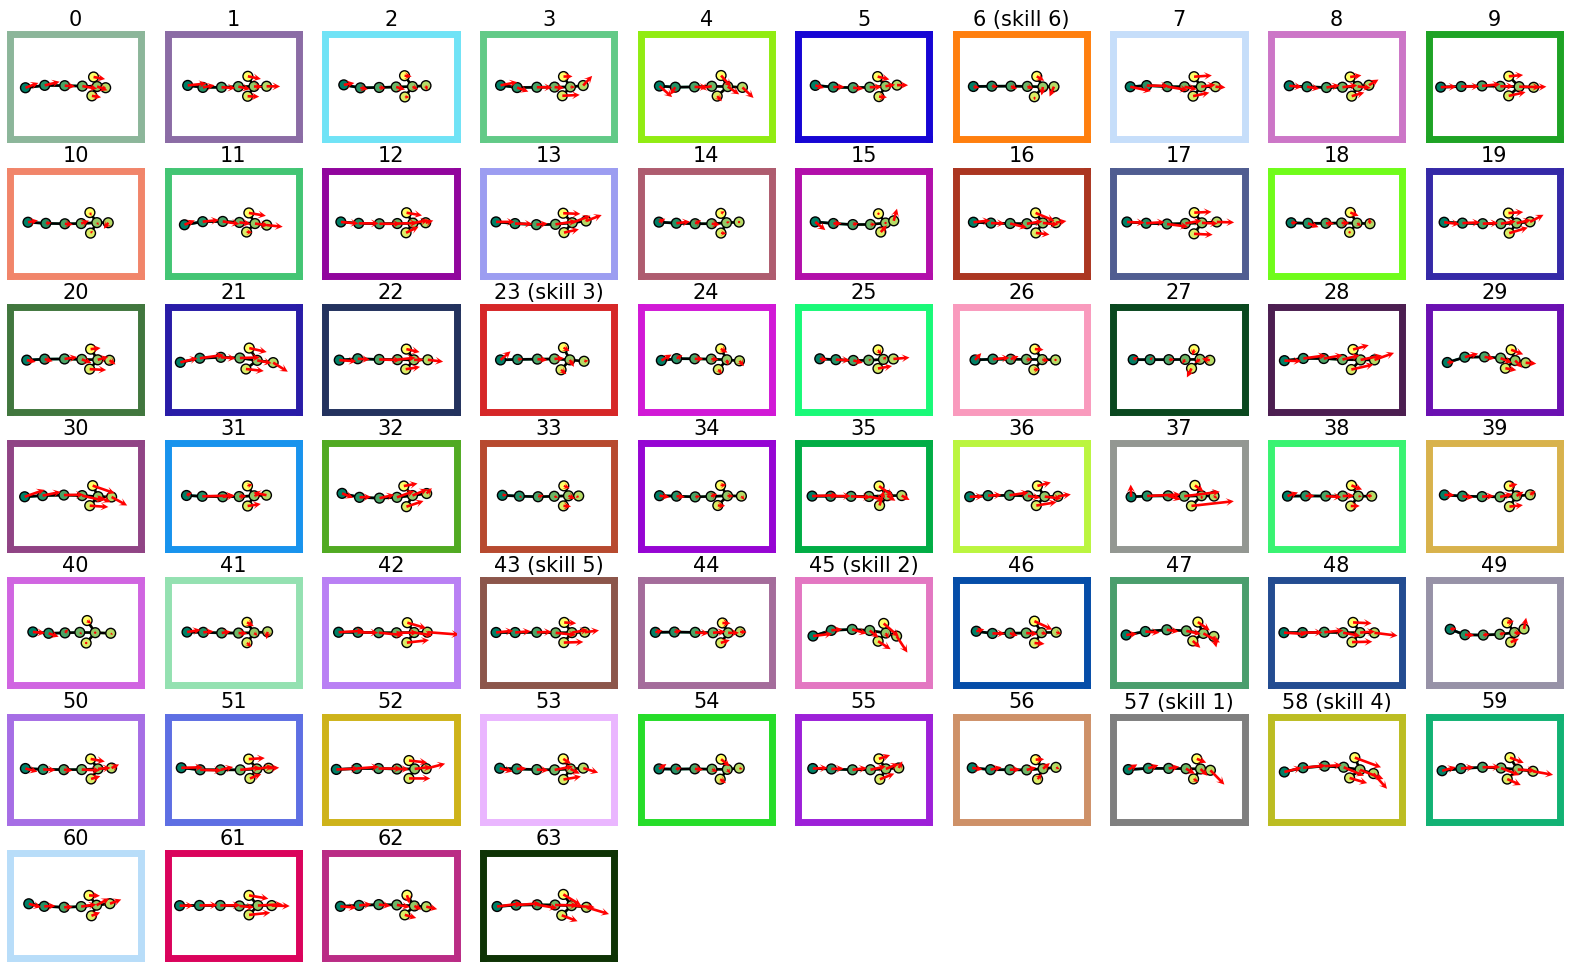

In [40]:
fig, ax = plt.subplots(7,10, figsize=(20, 12))
ax = ax.flatten()
show_sa_all(ax, average_state_ar, average_action_ar, np.arange(average_state_ar.shape[0]), 
            plt.cm.get_cmap('tab10'), skill_colors=colordict, mapping=mapping)
for i in range(average_state_ar.shape[0], len(ax)):
  ax[i].axis('off')
plt.subplots_adjust(hspace=0.3)
plt.savefig('./keymoseq/appendix/skill_all.pdf', dpi=400, bbox_inches='tight')

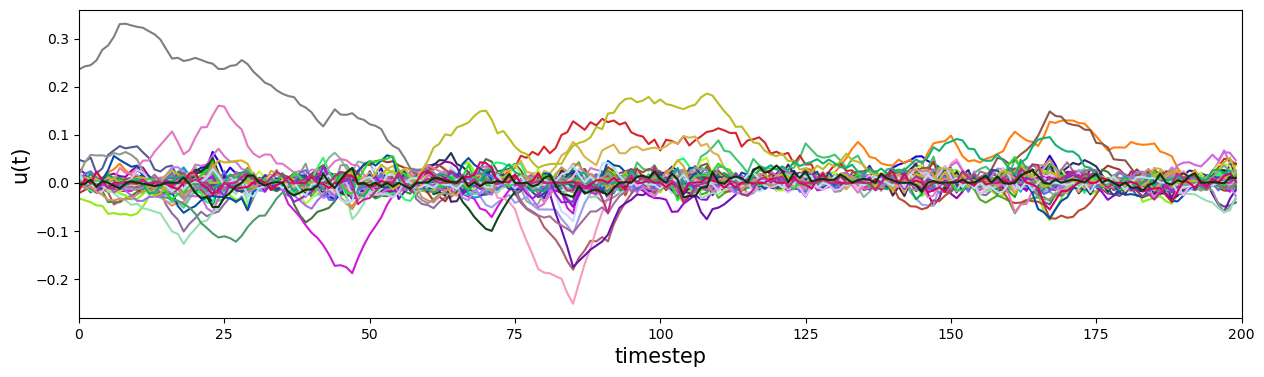

In [41]:
fig, ax = plt.subplots(figsize=(15,4))
skill_cmap = plt.cm.get_cmap('tab10')      
for j in range(u_matrix.shape[1]):
    ax.plot(u_matrix[:200,j], label=f'{j}', color=colordict[j])
ax.set_xlim(0, 200)
ax.set_xlabel('timestep', fontsize=15)
ax.set_ylabel('u(t)', fontsize=15)
plt.savefig('./keymoseq/appendix/u_matrix.pdf', dpi=400, bbox_inches='tight')

In [48]:
from matplotlib.animation import FFMpegWriter

def pair_gif_and_u(stateseq, u_matrix, taskseq, average_state_ar, average_action_ar, save_path, dpi):
  colordict = {57: colors[7], 45: colors[6], 23: colors[3], 58: colors[8], 43: colors[5], 6: colors[1]}
  mapping = {57:1, 45:2, 23:3, 58:4, 43:5, 6:6}
  np.random.seed(0)
  for i in range(average_state_ar.shape[0]):
    if i not in colordict:
      colordict[i] = tuple(np.random.rand(3,))

  # stateseq: [timestep, state_dim]
  # u_matrix: [timestep, feature_dim]
  # taskseq: [timestep, 1]
  # average_state_ar: [feature_dim, state_dim]
  # average_action_ar: [feature_dim, action_dim]
  writer = FFMpegWriter(fps=15)

  edges, state_name, n_dim = get_edges(stateseq.shape[-1])
  n_bodyparts = len(state_name)
  timestep = stateseq.shape[0]
  cmap = plt.cm.get_cmap('viridis')
  keypoint_colors = cmap(np.linspace(0, 1, len(state_name)))
  state_seq_to_plot = stateseq.reshape(timestep, n_bodyparts, 2)
  state_seq_to_plot -= state_seq_to_plot.mean(axis=(0,1), keepdims=True)
  taskseq_to_plot = taskseq.reshape(-1)
  axmin = -0.2
  axmax = 0.2
  aymin = -0.2
  aymax = 0.2
  ymin = np.min(state_seq_to_plot[...,1], axis=(-1,-2))         
  ymax = np.max(state_seq_to_plot[...,1], axis=(-1,-2))
  xmin = np.min(state_seq_to_plot[...,0], axis=(-1,-2))
  xmax = np.max(state_seq_to_plot[...,0], axis=(-1,-2))   
  indicator = np.where((aymin > ymin) | (aymax < ymax) | (axmin > xmin) | (axmax < xmax), 1, 0)
  aymin = np.where(indicator, -0.5, aymin)
  aymax = np.where(indicator, 0.8, aymax)
  axmin = np.where(indicator, -0.7, axmin)
  axmax = np.where(indicator, 0.6, axmax) 
  fig_width, fig_height = 16, 4+3
  n_skill_shown = 6
  ax0_left = 0.8
  ax0_width = ax0_height = ax1_height = 3.2
  ax0_bottom = ax1_bottom = 0.48+3
  ax1_left = ax_kmslabel_left = 4.8
  ax1_width = ax_kmslabel_width = 10.88
  ax_kmslabel_bottom = 0.2+3
  ax_kmslabel_height = ax1_bottom - ax_kmslabel_bottom
  
  ax_skill_bottom = 0.3
  ax_skill_hspace = 0.2
  ax_gap_hspace = 0.3
  ax_skill_width = ax_skill_height = (fig_width - ax0_left*2 - ax_skill_hspace*(n_skill_shown-1))/n_skill_shown
  ax_skill_left = [ax0_left+(ax_skill_width+ax_skill_hspace)*i for i in range(n_skill_shown)]
  ax_skill_left = [x-ax_gap_hspace if i < n_skill_shown//2 else x+ax_gap_hspace for i, x in enumerate(ax_skill_left)]
  

  fig = plt.figure(figsize=(fig_width, fig_height))
  ax0 = fig.add_axes([ax0_left/fig_width, ax0_bottom/fig_height, ax0_width/fig_width, ax0_height/fig_height])
  ax1 = fig.add_axes([ax1_left/fig_width, ax1_bottom/fig_height, ax1_width/fig_width, ax1_height/fig_height])
  ax_kmslabel = fig.add_axes([ax_kmslabel_left/fig_width, ax_kmslabel_bottom/fig_height, ax_kmslabel_width/fig_width, ax_kmslabel_height/fig_height])
  ax_skill = [fig.add_axes([ax_skill_left[i]/fig_width, ax_skill_bottom/fig_height, ax_skill_width/fig_width, ax_skill_height/fig_height]) for i in range(n_skill_shown)]

  # set_ax_color_width(ax_skill[1], 'orange', 10)
  # set_ax_color_width(ax_skill[4], 'g', 10)
  ax_kmslabel.axis('off')
  ax0.axis('off')
  skill_cmap = plt.cm.get_cmap('Set1')
  rasters = []
  with writer.saving(fig, save_path, dpi=dpi):
    for i in range(timestep):
      ax0.clear()
      ax1.clear()
      ax_kmslabel.clear()
      [ax_skill[i].clear() for i in range(n_skill_shown)]
      ax0.set_xlim(axmin, axmax)
      ax0.set_ylim(aymin, aymax)
      ax1.set_xlim(0, u_matrix.shape[0])
      ax1.set_ylim(u_matrix.min(), u_matrix.max())
      ax_kmslabel.set_xlim(0, u_matrix.shape[0])
      ax_kmslabel.set_ylim(0, 1)
      for p1, p2 in edges:
        ax0.plot(
            *state_seq_to_plot[i, (p1, p2)].T,
            color=keypoint_colors[p1],
            linewidth=5.0,zorder=0)
      ax0.scatter(
          *state_seq_to_plot[i].T,
          c=keypoint_colors,
          s=100,zorder=1)
      u_matrix_idx = np.argsort(u_matrix, 1)
      skill_idx_to_plot = np.array([u_matrix_idx[i, -1], u_matrix_idx[i, -2], u_matrix_idx[i, -3],
                      u_matrix_idx[i, 2], u_matrix_idx[i, 1], u_matrix_idx[i, 0]])
      for j in range(u_matrix.shape[1]):
        y = u_matrix[:,j]
        # print((u_matrix_idx[:,-1]==j).shape)
        # y = np.where((u_matrix_idx[:, -1] == j) | (u_matrix_idx[:, -2] == j) | (u_matrix_idx[:, -3] == j), y, np.nan)
        ax1.plot(y, label=f'{j}', color=colordict[j])
        # ax1.plot(u_matrix[:,j], label=f'{j}', color=skill_cmap.colors[j%len(skill_cmap.colors)])
      # for j in range(skill_idx_to_plot.shape[0]-3):
      #   ax1.plot(u_matrix[:, skill_idx_to_plot[j]], label=f'{skill_idx_to_plot[j]}', color=skill_cmap.colors[skill_idx_to_plot[j]%len(skill_cmap.colors)])
      
      ax1.vlines(i, ymin=u_matrix.min(), ymax=u_matrix.max(), color='black', linestyle='--')
      ax1.set_ylim(u_matrix.min(), u_matrix.max())
      # ax1.legend(loc='upper right', fontsize=8)
      ax1.set_xticks([])
      ax1.set_title(f'{i}')
      

      state_all = average_state_ar[skill_idx_to_plot]
      action_all = average_action_ar[skill_idx_to_plot]
      skill_colors = [colordict[i] for i in skill_idx_to_plot]
      show_sa_all(ax_skill, state_all, action_all, skill_idx_to_plot, skill_cmap, skill_colors=skill_colors, mapping=mapping)
      ax_skill[1].set_xlabel('Highest', fontsize=15, labelpad=4)
      ax_skill[4].set_xlabel('Lowest', fontsize=15, labelpad=4)


      ax_kmslabel.imshow(taskseq_to_plot.reshape(1,-1), aspect='auto', cmap='Set2',
                        extent=[0, u_matrix.shape[0], 0, 1])
      ax_kmslabel.set_yticks([])
      ax_kmslabel.set_xticks([])
      ax_kmslabel.set_xlabel('keymoseq label')
      ax_kmslabel.vlines(i, ymin=0, ymax=1, color='black', linestyle='--')
      # mark the task on the axis
      task_transition = np.where(np.diff(taskseq_to_plot))[0]
      task_unique_order = taskseq_to_plot[task_transition+1]
      task_unique_order = np.concatenate(([taskseq_to_plot[0]], task_unique_order))
      task_transition = np.concatenate(([0], task_transition, [taskseq_to_plot.shape[0]-1]))

      task_idx = {6:0, 8:1, 1:2, 0:3, 2:4}
      for j in range(len(task_unique_order)):
        xcoord = (task_transition[j] + task_transition[j+1]) / 2 + 0.5
        ax_kmslabel.annotate(f'{task_idx[int(task_unique_order[j])]}', xy=(xcoord, 0.5),
                          fontsize=14, ha='center', va='center')
      # rasters.append(rasterize_figure(fig))
      writer.grab_frame()
  # writer.finish()
  plt.close(fig)
  print(save_path)
  # pil_images = [Image.fromarray(np.uint8(img)) for img in rasters]
  # Save the PIL Images as an animated GIF
  # if not os.path.exists(os.path.dirname(save_path)):
  #   os.makedirs(os.path.dirname(save_path))
  # pil_images[0].save(
  #     save_path,
  #     save_all=True,
  #     append_images=pil_images[1:],
  #     duration=100,
  #     loop=0,
  # )
  # print(save_path)
  # convert_gif_to_mp4(save_path)

In [ ]:
pair_gif_and_u(initial_state[:200], u_matrix[:200], initial_task[:200],
                 average_state_ar, average_action_ar,
                 f'./keymoseq/appendix/video.mp4',
                 dpi=100)

./keymoseq/appendix/video.mp4
